# Baseline code V 2.1

Goals:

* Produce a simple code for study and research on FWI and HPC
* Use modern scientific code style and good practices
* Use Python as code integration framework
* Computationally intensive code can be done in external C/Fortran functions

# Note on *numpy* arrays

Using numpy arrays is a good practice for most scientific and data science applications. With numpy arrays it is easy to vectorize code, as well as migrate to other frameworks like Numba, Tensofflow, Pytorch, etc.

# Calling external C/C++ code

There are several libraries for integrating Python and external code on C/C++ and Fortran including: ctypes, cffi, pybind11, cython, and others. In this notebook we will use _ctypes_. Additional material:
* (Short tutorial)[https://realpython.com/python-bindings-overview/] on ctypes, cffi, pybind11, cython, and others
* (Processing a numpy array in native code)[https://tehnokv.com/posts/numpy-to-native/]
* (Hybrid Python/C++ packages with pybind11)[https://www.benjack.io/2018/02/02/python-cpp-revisited.html]


In [1]:
import numpy as np
# modulos para usar biblioteca externa
import os
import time
import ctypes
from numpy.ctypeslib import ndpointer
# Exibição, graficos etc
from matplotlib import pyplot, cm
import matplotlib.pylab as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D    ##New Library required for projected 3d plots
import seaborn as sns

def create_2Dgrid(nx, ny): 
    """
    Creates a 2D grid for finite differences calculation.
    nx, ny: gir dimensions (ints).
    return: a 2D numpy array with ones.
    """
    u = np.zeros((ny, nx), dtype=np.float32)
    return u

def set_initial_conditions_2D(u, nx, ny, value, x, y): 
    """
    Set grid initial conditions by filling grid positions with
    'value'. Injects a Ricker wavelet at coordinates (x,y).
    nx, ny: gir dimensions (ints).
    x, y: source coordinates.
    return: a 2D numpy array of (nx,ny) elements.
    """
    u[:] = value 
    # Acrescenta sinal da fonte como condição inicial
    #u_next[int(.5 / dy):int(.55 / dy),int(.5 / dx):int(.55 / dx)] = 0 
    wavelet = [0.016387336, -0.041464937, -0.067372555, 0.386110067,
                         0.812723635, 0.416998396,  0.076488599,  -0.059434419,
                         0.023680172, 0.005611435,  0.001823209,  -0.000720549]
    for s in range(10,0,-1):
        for i in range (x - s, x + s - 1, 1):
            for j in range (y - s, y + s -1, 1):
                u[i,j] = wavelet[s]
    return u

def plot_grid_2D_as_heatmap(u, nx, ny): 
    """
    Plot a grid image.
    nx, ny: gir dimensions (ints).
    """
    x = np.linspace(0, 2, nx)
    y = np.linspace(0, 2, ny)
    
    ax = sns.heatmap(u, cmap="YlGnBu")
    plt.show()
    
def simulate_iso2d(u_next, nx, ny, nt, print_every): 
    """
    Simulates 'nt'time steps of the isotropic acoustic wave propagation on the 2D grid.
    If the 'print_every' > 0, then the grid is printed every 'print_every' steps. 
    nx, ny: gir dimensions (ints).
    Returns the final value for the wavefield.
    """
    u_val  = create_2Dgrid(nx,ny)  ##                ... for the actuar value
    u_prev = create_2Dgrid(nx,ny)  ##                ... for the previous value
    # loop no tempo 
    for n in range(nt):
        u_prev = u_val.copy()
        u_val = u_next.copy()
        u_next[1:nx-1,1:ny-1] = 2 * u_val[1:nx-1,1:ny-1] - u_prev[1:nx-1,1:ny-1] + (dt * dt * c * c * (
            ((u_val[2:nx  ,1:ny-1] - 2 * u_val[1:nx-1,1:ny-1] + u_val[0:nx-2,1:ny-1])/(dx * dx))+
            ((u_val[1:nx-1,2:ny  ] - 2 * u_val[1:nx-1,1:ny-1] + u_val[1:nx-1,0:ny-2])/(dy * dy)))
        )
        if (print_every > 0):
            if (n % print_every)==0:
                plot_grid_2D_as_heatmap(u_next, nx, ny)
                print(' **  timestep n = '+str(n))
    return u_next 

def simulate_iso2dVel(u_next, vpmodel, nx, ny, nt, dx, dy, dt, print_every): 
    """
    Simulates 'nt'time steps of the isotropic acoustic wave propagation on the 2D grid.
    If the 'print_every' > 0, then the grid is printed every 'print_every' steps. 
    nx, ny: gir dimensions (ints).
    Returns the final value for the wavefield.
    """
    u_val  = create_2Dgrid(nx,ny)  ##                ... for the actuar value
    u_prev = create_2Dgrid(nx,ny)  ##                ... for the previous value
    # loop no tempo 
    for n in range(nt):
        u_prev = u_val.copy()
        u_val = u_next.copy()
        u_next[1:nx-1,1:ny-1] = 2 * u_val[1:nx-1,1:ny-1] - u_prev[1:nx-1,1:ny-1] + (dt * dt * c * c * (
            ((u_val[2:nx  ,1:ny-1] - 2 * u_val[1:nx-1,1:ny-1] + u_val[0:nx-2,1:ny-1])/(dx * dx))+
            ((u_val[1:nx-1,2:ny  ] - 2 * u_val[1:nx-1,1:ny-1] + u_val[1:nx-1,0:ny-2])/(dy * dy)))
        )
        if (print_every > 0):
            if (n % print_every)==0:
                plot_grid_2D_as_heatmap(u_next, nx, ny)
                print(' **  timestep n = '+str(n))
    return u_next 

    
    
# Dimensões do grid 2D 
nx = 512
ny = 512
nt = 1000    # numero de timesteps

c = 1.5       # velocidade da onda (igual em todo o dominio)
#dx = 2 / (nx - 1)
#dy = 2 / (ny - 1)
sigma = .2
dx = 15.  # 15 metros
dy = 15.  # 15 metros
dt = 2.624453295839119
# dt = sigma * dx    # condição de estabilidade: dt < dx / 5

#u_next = create_2Dgrid(nx,ny)
# Cria grid e injeta uma fonte Ricker no centro do domínio
#u_next = set_initial_conditions_2D(u_next, nx, ny, 1.0, nx//2, ny//2)
#plot_grid_2D_as_heatmap(u_next, nx, ny)

#t1 = time.time()
#u_next = simulate_iso2d(u_next, nx, ny, 10, 10)
#print('elapsed time is '+str(time.time()-t1))


Next we will create a C code that receives a matrix and modify it. The C code can be either created in a separate file or created by our Python program. Let's do the later.

 *** Exemplo Python 


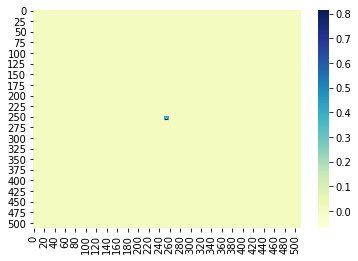

Tempo gasto = 2.4980661869049072
 Resultado:


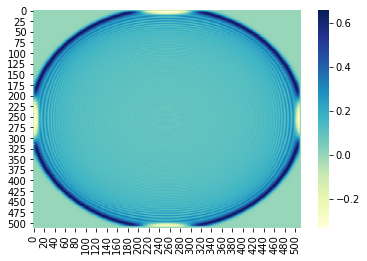

In [2]:
def create_native_lib(): 
    """
    Create the C code and library files.
    """
    # Trecho de código em C
    # gera a biblioteca e carrega
    src = '''#include <stddef.h>
    void cfun(const double *indatav, size_t size, double *outdatav){
        size_t i;
        for (i = 0; i < size; ++i)
            outdatav[i] = indatav[i] * 10.0;
    }
    void cfun32(const float *indatav, size_t size, float *outdatav){
        size_t i;
        for (i = 0; i < size; ++i)
            outdatav[i] = indatav[i] * 10.0;
    }
    float compute_mean(float* A, int n){
        int i;
        float sum = 0.0f;
        for(i=0; i<n; ++i)
            sum += A[i];
        return sum/n;
    }
    '''
    # Criando o programa C
    f = open('notebook-lib.c', 'w')
    f.write(src)
    f.close()
    # compila o codigo C como uma biblioteca compartilhada nativa
    os.system('cc notebook-lib.c -fPIC -shared -o notebook-lib.so')
    os.system('ls -l')

    
def cleanup_native_lib(): 
    """
    Remove native source and library.
    """
    os.system('rm notebook-lib.c')
    os.system('rm notebook-lib.so')

def load_native_lib():
    # https://docs.python.org/3.5/library/ctypes.html#loading-shared-libraries
    lib = ctypes.cdll.LoadLibrary("notebook-lib.so")
    fun = lib.cfun
    fun.restype = None
    fun.argtypes = [ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"),
                    ctypes.c_size_t,
                    ndpointer(ctypes.c_double, flags="C_CONTIGUOUS")]
    return lib

def load_rotinas_lib():
    # https://docs.python.org/3.5/library/ctypes.html#loading-shared-libraries
    lib = ctypes.cdll.LoadLibrary("rotinas.so")
    fun = lib.acoustic_forward 
    fun.restype = None    
    fun.argtypes = [ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),                    
                    ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                    ctypes.c_size_t,
                    ctypes.c_size_t,
                    ctypes.c_size_t,
                    ctypes.c_float,
                    ctypes.c_float,
                    ctypes.c_float,
                    ctypes.c_int]    
    return fun

# Pode-se criar uma função em python que atua como um wrapper
def wrap_fun(indata, outdata):
    assert indata.size == outdata.size
    fun(indata, indata.size, outdata)

# lixo ------
def wrap_fun32(indata, outdata):
    assert indata.size == outdata.size
    fun32(indata, indata.size, outdata)

# ------------------ main

nx = 512
ny = 512
nt = 1000    # numero de timesteps

c = 1.5       # velocidade da onda (igual em todo o dominio)
dx = 15.  # 15 metros
dy = 15.  # 15 metros
dt = 2.624453295839119

print(' *** Exemplo Python ')
v1 = create_2Dgrid(nx,ny) 
v1 = set_initial_conditions_2D(v1, nx, ny, 0, nx//2, ny//2)      
#v2 = create_2Dgrid(nx,ny)
vel = create_2Dgrid(nx,ny)
vel[:]= c * c

plot_grid_2D_as_heatmap(v1,nx,ny)

t1 = time.time()
simulate_iso2dVel(v1, vel, nx, ny, nt, dx, dy, dt, print_every=0)
print("Tempo gasto =",time.time()-t1)
print(" Resultado:")
plot_grid_2D_as_heatmap(v1,nx,ny)


# Criar o arquivo de biblioteca
#create_native_lib()
